# Machine Learning with Broad Stock Market Timeseries - a SARIMA Rollercoaster


<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

C:\Users\adamd\AppData\Local\Temp\ipykernel_13224\3477214583.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Financial Data

Collect market time series data (like stock prices, trading volumes, etc.).
Clean the data to handle missing values, outliers, or anomalies.
Ensure the data is in a time series format, typically with a timestamp.

In [2]:
START_DATE = "2009-01-01"
END_DATE = "2023-12-31"
DATA_DIR = "data"
PRICE_FEATURES = ["Open", "High", "Low"]
INDEX = "Date"

os.makedirs(DATA_DIR, exist_ok=True)

TARGET_ETF = "SPY"  # S&P 500
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
MACRO_INDEX = "VEU"  # Vanguard FTSE All-World ex-US ETF
TECH_INDEX = "QQQ"
SMALLCAP_INDEX = "R2US.MI"

tickers_symbols = [
    TARGET_ETF,
    VOLATILITY_INDEX,
    RATES_INDEX,
    MACRO_INDEX,
    TECH_INDEX,
    SMALLCAP_INDEX,
]

tickers = {}
for symbol in tickers_symbols:
    cached_file_path = f"{DATA_DIR}/{symbol}-{START_DATE}-{END_DATE}.csv"

    try:
        if os.path.exists(cached_file_path):
            df = pd.read_csv(cached_file_path, index_col=INDEX)
            df.index = pd.to_datetime(df.index)
            assert len(df) > 0
        else:
            df = yf.download(
                symbol, start=START_DATE, end=END_DATE, progress=False, interval="1d"
            )
            assert len(df) > 0
            df.to_csv(cached_file_path)
        df.fillna(0, inplace=True)
        tickers[symbol] = df
    except Exception as e:
        print(f"Error with {symbol}: {e}")


sp500_df = tickers.get(TARGET_ETF)
vix_df = tickers.get(VOLATILITY_INDEX)
t10ytt_df = tickers.get(RATES_INDEX)
veu_df = tickers.get(MACRO_INDEX)

assert not sp500_df[PRICE_FEATURES].isna().any().any()

sp500_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-15,131.800003,132.369995,131.410004,132.039993,103.956963,170006700
2011-04-18,130.589996,132.029999,129.509995,130.559998,102.791718,210759300
2011-04-19,130.759995,131.350006,130.440002,131.309998,103.382225,124258800
2011-04-20,132.880005,133.389999,132.789993,133.100006,104.791519,156133800
2011-04-21,133.789993,133.839996,133.100006,133.779999,105.326866,135935400


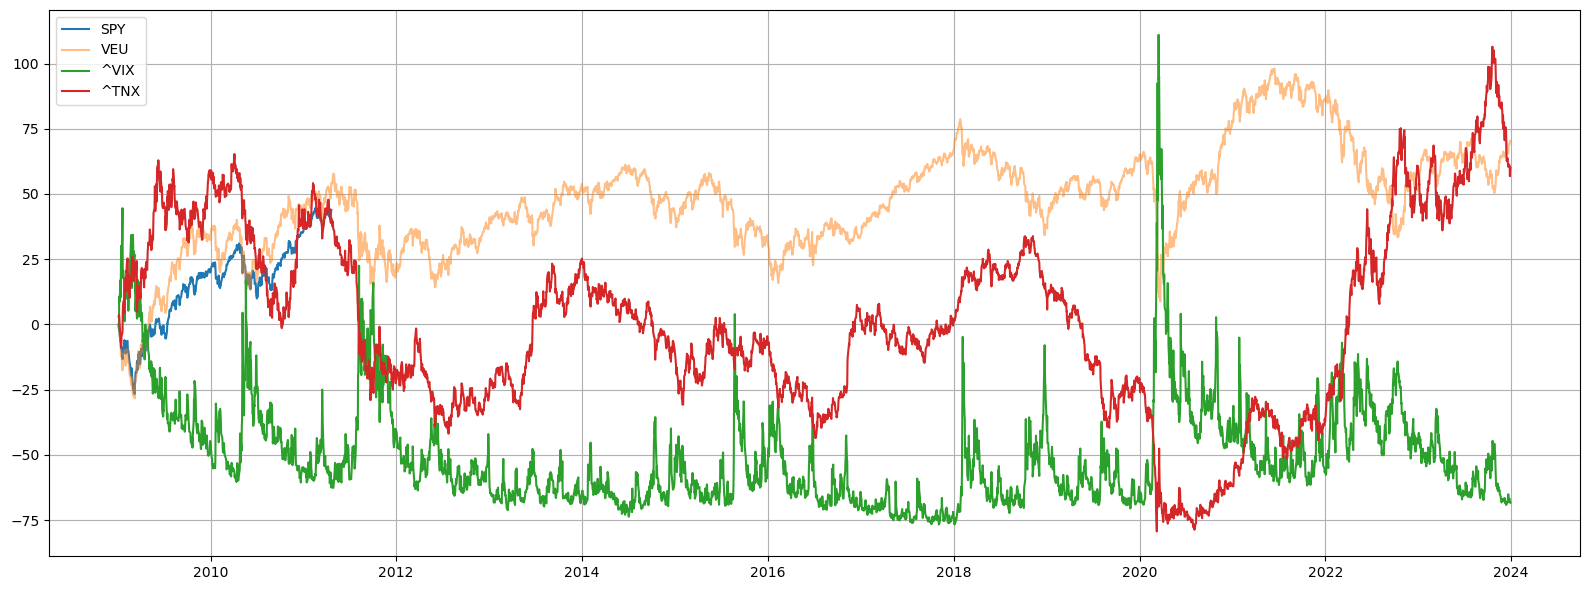

In [3]:
sp500_pr = ((1 + sp500_df["Close"].pct_change()).cumprod() - 1) * 100
veu_pr = ((1 + veu_df["Close"].pct_change()).cumprod() - 1) * 100
vix_pr = ((1 + vix_df["Close"].pct_change()).cumprod() - 1) * 100
tnx_pr = ((1 + t10ytt_df["Close"].pct_change()).cumprod() - 1) * 100

plt.figure(figsize=(16, 6))
plt.plot(sp500_pr, label=TARGET_ETF)
plt.plot(veu_pr, label=MACRO_INDEX, alpha=0.5)
plt.plot(vix_pr, label=VOLATILITY_INDEX)
plt.plot(tnx_pr, label=RATES_INDEX)

plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

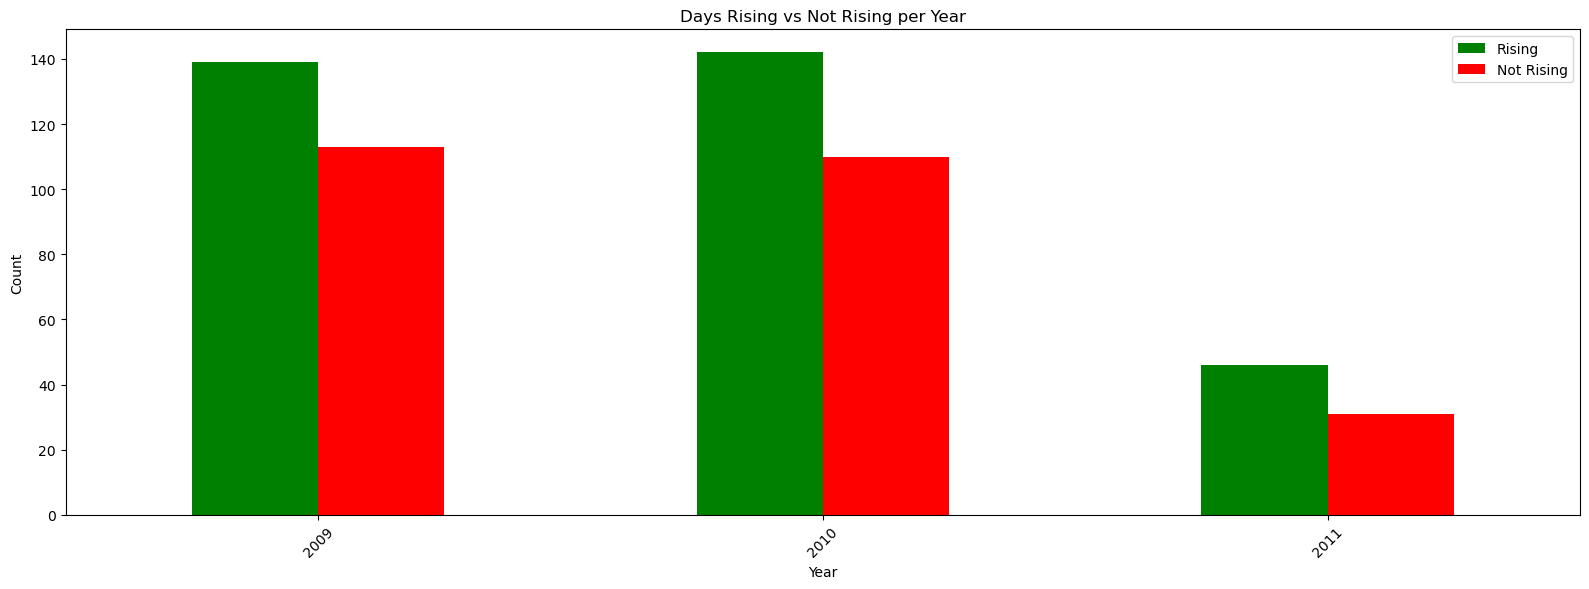

Baseline Accuracy: 57.08%


In [4]:
days_rising = sp500_df[sp500_df["Close"] > sp500_df["Open"]]
days_not_rising = sp500_df[sp500_df["Close"] <= sp500_df["Open"]]
days_rising_count = days_rising.groupby(days_rising.index.year).size()
days_not_rising_count = days_not_rising.groupby(days_not_rising.index.year).size()

total_days = sp500_df.groupby(sp500_df.index.year).size()
percentage_rising = (days_rising_count / total_days) * 100

yearly_counts = pd.DataFrame(
    {"Rising": days_rising_count, "Not Rising": days_not_rising_count}
)
yearly_counts.plot(kind="bar", color=["green", "red"], figsize=(16, 6))
plt.title("Days Rising vs Not Rising per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Baseline Accuracy: {percentage_rising.mean():0.2f}%")

# Model Architecture

In [5]:
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Normalization,
    Add,
    Input,
    Lambda,
)
from tensorflow.keras import Model


class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=None,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        # Capture feature set from the input
        self.conv1 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_1_{id}",
        )

        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation="relu",
            name=f"Conv1D_2_{id}",
        )
        self.dropout2 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{id}"
        )

        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Conv1D_skipconnection_{id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{id}")

    def apply_block(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back:
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x


def TCN(
    input_shape,
    output_horizon=1,
    num_filters=32,
    num_layers=1,
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.0,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """
    x = inputs = Input(shape=input_shape)
    for i in range(num_layers):
        block = TCNBlock(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate**i,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            id=i,
        )
        x = block.apply_block(x)
    # Selects the last timestep and predict in the 1 DIM layer.
    x = Lambda(lambda x: x[:, -output_horizon:, 0], name="lambda_last_timestep")(x)
    outputs = Dense(output_horizon, name="Dense_singleoutput", activation="linear")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TCN")
    return model

# Feature Engineering

In [6]:
from sklearn.preprocessing import FunctionTransformer

MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"
DAY_SINE = "day_sin"
DAY_COS = "day_cos"
Q_SINE = "quart_sin"
Q_COS = "quart_cos"
BIZ_SINE = "biz_sin"
BIZ_COS = "biz_cos"
FACTOR_COSTS = 0.0025  # Assume 2.5% commissions.
FACTOR_SPREAD = 0.0003  # assume 0.3% spread & slippage.
FACTOR_AVG_MOVE = (
    0  # (tickers.get(TARGET_ETF)["Close"].tail(365*2).pct_change().mean() / 4)
)
TARGET_FACTOR = FACTOR_COSTS + FACTOR_SPREAD + FACTOR_AVG_MOVE
TARGET = "Close_target"
TIME_FEATURES = [
    DAY_SINE,
    DAY_COS,
    MONTH_SINE,
    MONTH_COS,
    BIZ_SINE,
    BIZ_COS,
    Q_SINE,
    Q_COS,
]
FEATURES = [
    "Volume",
    RATES_INDEX,
    MACRO_INDEX,
    VOLATILITY_INDEX,
    TECH_INDEX,
    SMALLCAP_INDEX,
]
EXT_FEATURES = FEATURES + PRICE_FEATURES + TIME_FEATURES
WINDOW_SIZE = int(252 / 4)  # 1 years trading, sampled across days
PREDICTION_HORIZON = 1  # next 1 trading day

print(f"target factor used: {TARGET_FACTOR}")


def encode_timewindows(data_df, features, target, window_size, horizon):
    """
    Create input and target windows suitable for TCN model.
    :param data: DataFrame with shape (n_samples, n_features)
    :param features: List of strings, names of the feature columns
    :param target: String, name of the target column
    :param window_size: int, length of the input sequence.
    :param horizon: int, forecasting horizon.
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    X, y = [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"
    ):
        input_window = data_df[features].iloc[i : i + window_size].values
        X.append(input_window)
        if horizon == 1:
            target_value = data_df[target].iloc[i + window_size]
        else:
            target_value = (
                data_df[target].iloc[i + window_size : i + window_size + horizon].values
            )
        y.append(target_value)
    return np.array(X), np.array(y)


def create_time_features(data_df):
    """
    Encodes time cyclic features for a dataset with monthly sampling.
    Including cyclic encoding for day and year.
    :param data_df: The timeseries with a date in the format YYYY-MM-DD as index.
    :return: data_df with added wave features for month, day, and year.
    """
    if not isinstance(data_df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    def _sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

    def _cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    months = data_df.index.month
    data_df[MONTH_SINE] = _sin_transformer(12).fit_transform(months)
    data_df[MONTH_COS] = _cos_transformer(12).fit_transform(months)
    data_df[Q_SINE] = _sin_transformer(12 / 4).fit_transform(months)
    data_df[Q_COS] = _cos_transformer(12 / 4).fit_transform(months)
    data_df[BIZ_SINE] = _sin_transformer(12 * 5).fit_transform(months)
    data_df[BIZ_COS] = _cos_transformer(12 * 5).fit_transform(months)
    days = data_df.index.day
    data_df[DAY_SINE] = _sin_transformer(365).fit_transform(days)
    data_df[DAY_COS] = _cos_transformer(365).fit_transform(days)
    return data_df


def get_log_returns(data_df):
    return np.log(data_df / data_df.shift(1)).fillna(0)


def create_features_df(tickers):
    """
    Create all exogenous features that lead to our target etf.
        - if the trading day close is higher than the open.
        - price log returns
    """
    IDX_COL = "Open"

    data_df = tickers.get(TARGET_ETF).copy()
    data_df[TARGET] = (data_df["Close"] * (1 - TARGET_FACTOR)).astype(float)

    data_df[PRICE_FEATURES] = get_log_returns(data_df[PRICE_FEATURES])

    rates_df = tickers.get(RATES_INDEX)
    data_df[RATES_INDEX] = get_log_returns(rates_df[IDX_COL])
    macro_df = tickers.get(MACRO_INDEX)
    data_df[MACRO_INDEX] = get_log_returns(macro_df[IDX_COL])
    vix_df = tickers.get(VOLATILITY_INDEX)
    data_df[VOLATILITY_INDEX] = get_log_returns(vix_df[IDX_COL])
    data_df = data_df.fillna(0)

    tech_df = tickers.get(TECH_INDEX)
    data_df[TECH_INDEX] = get_log_returns(tech_df[IDX_COL])
    data_df = data_df.fillna(0)
    small_df = tickers.get(SMALLCAP_INDEX)
    data_df[SMALLCAP_INDEX] = get_log_returns(small_df[IDX_COL])
    data_df = data_df.fillna(0)

    return data_df


def prepare_data_and_windows(tickers, window=WINDOW_SIZE, horizon=PREDICTION_HORIZON):
    """
    Utility function to prepare the data.
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    data_df = create_features_df(tickers)

    normalizer = Normalization(axis=-1)
    normalizer.adapt(data_df[FEATURES])
    data_df_normalized = normalizer(data_df[FEATURES])

    data_df_normalized = pd.DataFrame(
        data_df_normalized.numpy(), columns=FEATURES, index=data_df.index
    )
    data_df_normalized = pd.concat(
        [data_df[TARGET], data_df[PRICE_FEATURES], data_df_normalized], axis=1
    )
    data_df_normalized = create_time_features(data_df_normalized)
    X, y = encode_timewindows(data_df_normalized, EXT_FEATURES, TARGET, window, horizon)
    print(
        f"FEATURES: {EXT_FEATURES}, TARGET: '{TARGET}', window: {WINDOW_SIZE}, horizon: {PREDICTION_HORIZON}"
    )
    print(
        f"Shape unencoded (including target label and superflous features): {data_df.shape}"
    )
    print(f"Shape encoded (window and selected exog features only): {X.shape}")
    return X, y, normalizer


# Yes, we are using the whole dataset not the training dataset.
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# we will tell keras to do a validation split, it will not fit on the validation data.

X, y, normalizer = prepare_data_and_windows(tickers)
print(f"Label shape encoded: {y.shape}")
print(f"Data shape: {X.shape}")
print(f"First window exog normalized: {X[0,  :]}")
print(f"First window targets: {y[:WINDOW_SIZE]}")

target factor used: 0.0028


Encoding Widows: 100%|██████████| 518/518 [00:00<00:00, 1474.37it/s]

FEATURES: ['Volume', '^TNX', 'VEU', '^VIX', 'QQQ', 'R2US.MI', 'Open', 'High', 'Low', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'biz_sin', 'biz_cos', 'quart_sin', 'quart_cos'], TARGET: 'Close_target', window: 63, horizon: 1
Shape unencoded (including target label and superflous features): (581, 12)
Shape encoded (window and selected exog features only): (518, 63, 17)
Label shape encoded: (518,)
Data shape: (518, 63, 17)
First window exog normalized: [[ 8.52730423e-02 -3.21579948e-02 -4.62142415e-02 ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [ 2.22187340e-01  5.17863131e+00  6.08766317e-01 ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 [ 1.16374493e+00  1.20343947e+00  4.94107425e-01 ...  9.94521895e-01
   8.66025404e-01 -5.00000000e-01]
 ...
 [ 1.54907477e+00  5.72222710e-01  3.78482997e-01 ...  9.51056516e-01
  -2.44929360e-16  1.00000000e+00]
 [ 1.68595266e+00 -1.31451046e+00  1.72290318e-02 ...  9.13545458e-01
   8.66025404e-01 -5.00000000e-01]
 [ 2.748549

In [7]:
print(f"Last window exog normalized: {X[-1,  :]}")
print(f"Last window targets: {y[-WINDOW_SIZE:]}")

input_shape = (WINDOW_SIZE, X.shape[2])
input_shape

Last window exog normalized: [[-0.72981924  0.89792824  0.24774972 ...  0.9945219   0.8660254
  -0.5       ]
 [-1.13410616 -0.25964233 -0.35246122 ...  0.9945219   0.8660254
  -0.5       ]
 [-0.55749768 -0.58048785  0.17444386 ...  0.9945219   0.8660254
  -0.5       ]
 ...
 [-0.09473549 -1.22090399 -1.12250483 ...  0.91354546  0.8660254
  -0.5       ]
 [-1.02118397  0.23626018  0.23070873 ...  0.91354546  0.8660254
  -0.5       ]
 [-0.67979246  0.05694589  1.44822967 ...  0.91354546  0.8660254
  -0.5       ]]
Last window targets: [128.73852609 128.80832217 129.30692217 129.62603348 127.36238522
 128.3196887  130.37393348 130.12463348 130.41381478 130.78277391
 131.60048522 132.1988113  131.89964826 131.9495113  132.73729261
 133.0563887  132.63756652 133.47522609 133.8741     134.15331478
 131.46087783 130.65314826 130.5633887  131.95947783 132.77717391
 130.5633887  130.8426187  133.09628522 132.09908522 131.0619887
 132.20877783 132.01930739 129.57617043 130.47364435 129.68586304
 12

(63, 17)

In [ ]:
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, tick_label=unique)
plt.title("Distribution of Close > Open == 1")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

# Train Model

In [ ]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow_addons.metrics import F1Score
from datetime import datetime
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import json
import pickle

VAL_SPLIT = 0.15
EPOCHS = 100
PATIENCE_EPOCHS = 10
BATCH_SIZE = 32
FILTER = 128
DROPRATE = 0.5
POOL_SIZE = 5
KERNEL_SIZE = 5
DILATION_RATE = KERNEL_SIZE
MAX_LAYERS = 5
L2_REG = 0.005
LEARN_RATE = 0.0001
MODEL_LOG_DIR = f'./logs/{datetime.now().strftime("%m%d-%H%M%S")}'
CV_SPLITS = 5
# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
# See paper: https://www.mdpi.com/2076-3417/10/7/2322
GRID = {
    "num_filters": [32, 128],
    "kernel_size": [2, 4, 16],
    "batch_size": [BATCH_SIZE],
    "epochs": [EPOCHS],
    "dilation_rate": [2, 4, 16],
    "dropout_rate": [0.3, 0.6],
    "num_layers": [6, 12],
    "l2_reg": [0.0005, 0.01],
    "learning_rate": [LEARN_RATE],
    "patience": [PATIENCE_EPOCHS],
}

print(f"Model logs for Tensorboard available here: {MODEL_LOG_DIR}")


def grid_search(input_shape, X, y, param_grid=GRID, file_name="best_params.json"):
    """Runs for 3 days!!!"""

    def _create_model(hyperparams):
        model = TCN(
            input_shape=input_shape,
            output_horizon=PREDICTION_HORIZON,
            num_filters=hyperparams["num_filters"],
            kernel_size=hyperparams["kernel_size"],
            num_layers=hyperparams["num_layers"],
            dilation_rate=hyperparams["dilation_rate"],
            kernel_regularizer=L2(l2=hyperparams["l2_reg"]),
            bias_regularizer=L2(l2=hyperparams["l2_reg"]),
            dropout_rate=hyperparams["dropout_rate"],
        )
        optimizer = Adam(hyperparams["learning_rate"])
        model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", "mape"])
        return model

    def _save_best_params(best_params, best_loss, file_name="best_params.json"):
        with open(file_name, "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss}, file)

    grid = list(ParameterGrid(param_grid))
    best_model = None
    best_loss = np.inf
    best_params = None

    for hyperparams in tqdm(grid, desc="Grid Search.."):
        model = _create_model(hyperparams)
        callbacks = [EarlyStopping(patience=hyperparams["patience"], monitor="val_mse")]
        history = model.fit(
            X,
            y,
            epochs=hyperparams["epochs"],
            batch_size=hyperparams["batch_size"],
            validation_split=VAL_SPLIT,
            verbose=0,
            callbacks=callbacks,
        )
        metric = np.min(history.history["val_mse"])

        if metric < best_loss:
            best_loss = metric
            best_model = model
            best_params = params
            _save_best_params(best_params, best_loss, file_name)

    return best_model, best_loss


def build_tcn(input_shape, X, y, Xt=None, yt=None, val_split=VAL_SPLIT):
    model = TCN(
        input_shape=input_shape,
        output_horizon=PREDICTION_HORIZON,
        num_filters=FILTER,
        kernel_size=KERNEL_SIZE,
        num_layers=MAX_LAYERS,
        dilation_rate=DILATION_RATE,
        kernel_regularizer=L2(l2=L2_REG),
        bias_regularizer=L2(l2=L2_REG),
    )
    optimizer = Adam(LEARN_RATE)
    # metrics = [Precision()]
    metrics = ["mse", "mae", "mape"]
    model.compile(loss="mse", optimizer=optimizer, metrics=metrics)
    callbacks = [
        EarlyStopping(
            patience=PATIENCE_EPOCHS, monitor="val_mse", restore_best_weights=True
        ),
        TensorBoard(log_dir=MODEL_LOG_DIR),
    ]
    history = model.fit(
        X,
        y,
        validation_data=(Xt, yt) if Xt is not None else None,
        validation_split=val_split if Xt is None else None,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
    )
    return model, history


def train_cv_model(X, y, input_shape, n_splits=CV_SPLITS):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = build_tcn(input_shape, X_train, y_train, X_test, y_test)


MODEL_DIR = f"./models/{datetime.now().strftime('%Y%m%d-%H')}"

os.makedirs(MODEL_DIR, exist_ok=True)
assert os.path.exists(MODEL_DIR)

# model = load_model(f"{MODEL_DIR}/tcn.h5")
# with open(f"{MODEL_DIR}/history.pkl", 'rb') as file:
#    loaded_history = pickle.load(file)
# model, history = build_tcn(input_shape, X, y)
model, history = build_tcn(input_shape, X, y)
model.save(f"{MODEL_DIR}/tcn.h5")
with open(f"{MODEL_DIR}/history.pkl", "wb") as file:
    pickle.dump(history.history, file)

model.summary()

# Evaluate

In [ ]:
VAL_SIZE = round(len(X) * VAL_SPLIT)

train_data = X[:-VAL_SIZE]
test_data = X[-VAL_SIZE:]
ytrain_data = y[:-VAL_SIZE]
ytest_data = y[-VAL_SIZE:]
print(f"Test data shape: {ytest_data.shape}")
print(f"Test data 1 horizon sample: {ytest_data[0]}")

y_pred = model.predict(train_data)
yt_pred = model.predict(test_data)

print(f"Prediction shape: {yt_pred.shape}")
print(f"Predition 1 horizon sample: {yt_pred[0].flatten()}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_flat = ytrain_data.flatten()
yt_flat = ytest_data.flatten()

print(f"shapes y: {ytrain_data.shape} and yt_pred: {ytest_data.shape}")
print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")
print(f"Next + binary shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")

accuracy_train = accuracy_score(y_flat, y_pred)
accuracy_test = accuracy_score(yt_flat, yt_pred)
precision_train = precision_score(y_flat, y_pred)
precision_test = precision_score(yt_flat, yt_pred)
recall_train = recall_score(y_flat, y_pred)
recall_test = recall_score(yt_flat, yt_pred)
f1_train = f1_score(y_flat, y_pred)
f1_test = f1_score(yt_flat, yt_pred)


metrics_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_train, accuracy_test],
        "Precision": [precision_train, precision_test],
        "Recall": [recall_train, recall_test],
        "F1 Score": [f1_train, f1_test],
    },
    index=["Train", "Test"],
)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    history.history["precision"],
    label="Train precision",
    linestyle="-.",
)
axs[1].plot(
    history.history["val_precision"],
    label="Test precision",
    linestyle="-",
)
axs[1].axhline(
    precision_train, linestyle="--", label="Train Precision", alpha=0.5, color="r"
)
axs[1].axhline(
    precision_test, linestyle="-", label="Test Precision", alpha=0.5, color="r"
)
axs[1].axhline(
    percentage_rising.mean() / 100,
    linestyle="-",
    label="Technical Base",
    alpha=0.5,
    color="k",
)
axs[1].axhline(f1_train, linestyle="--", label="Train F1", alpha=0.5, color="g")
axs[1].axhline(f1_test, linestyle="-", label="Test F1", alpha=0.5, color="g")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy/Precision")
axs[1].legend()

metrics_df

# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [Vanguard All World excluding US](https://investor.vanguard.com/investment-products/etfs/profile/veu)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.